<a href="https://colab.research.google.com/github/Token-05/FACERecognition/blob/main/facerecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U keras 
!pip install tensorflow
!pip list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 13.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 13.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
Package                       Version
----------------------------- ----------------------
absl-py              

In [ ]:
# 入力処理系
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
# ネットワーク系
import torch.nn as nn
import torch
from keras import models
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU, concatenate, GlobalAveragePooling2D, Input, BatchNormalization, SeparableConv2D, Subtract, concatenate, Conv2D, AveragePooling2D
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# version 1.0 (～中間発表)
# network : squeezenet(今のところ最速の学習率)
class faceid_beta:
    # 初期化
    def __init__(self, x):
        self.x = x
    
    # 同一人物の画像カップル
    def create_couple_rgbd(self):
        # ファイルパス
        under_vap_path, under_cap_path = random.randint(1, 51), random.randint(1, 3)
        # rgb(sync)
        im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncRGB/1.jpg'.format(under_vap_path,under_cap_path)))[140:340,220:420]
        im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncRGB/2.jpg'.format(under_vap_path,under_cap_path)))[140:340,220:420]
        # d(sync)
        imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncD/1.png'.format(under_vap_path,under_cap_path)))[140:340,220:420]
        imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncD/2.png'.format(under_vap_path,under_cap_path)))[140:340,220:420]
        # 正規化
        im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
        im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
        # 元の画像がRGBなのでRGBDに作り替える
        full1 = np.zeros((200,200,4))
        full1[:,:,:3] = im1[:,:,:3]
        full1[:,:,3] = im1_truth
        full2 = np.zeros((200,200,4))
        full2[:,:,:3] = im2[:,:,:3]
        full2[:,:,3] = im2_truth
        return np.array([full1, full2])
    
    # 同一人物でない画像カップル
    def create_wrong_rgbd(self):
        # ファイルパス
        under_vap_path = random.sample(list(range(1,52)),2)
        under_cap_path = random.sample(list(range(1,4)),2)
        # rgb(sync)
        im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncRGB/1.jpg'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
        im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncRGB/2.jpg'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
        # d(sync)
        imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncD/1.png'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
        imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/{}/SyncD/2.png'.format(under_vap_path[0],under_cap_path[1])))[140:340,220:420]
        # 正規化
        im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
        im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
        # 元の画像がRGBなのでRGBDに作り替える
        full1 = np.zeros((200,200,4))
        full1[:,:,:3] = im1[:,:,:3]
        full1[:,:,3] = im1_truth
        full2 = np.zeros((200,200,4))
        full2[:,:,:3] = im2[:,:,:3]
        full2[:,:,3] = im2_truth
        return np.array([full1, full2])
    
    # ユークリッド距離の導出(顔の類似度チェック)
    def euclidean_distance(self, inputs):
        assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
        u, v = inputs
        return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
    
    # 対となるサンプル同士の近傍・分離
    def contrastive_loss(self,y_true,y_pred):
        margin=1.0
        return K.mean((margin - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.0)))
        # return K.mean( K.square(y_pred) )
    
    # inception module (https://pystyle.info/pytorch-googlenet/#outline__2_2)
    def fire(self, x, squeeze=16, expand=64):
        x = Conv2D(squeeze, (1,1), padding='valid', activation='relu')(x)
        # 1x1だと端のデータも特徴量として算出しやすい
        left = Conv2D(expand, (1,1), padding='valid', activation='relu')(x)
        # 3x3だと厳しいのでゼロパディングして端のデータに対して調整
        right = Conv2D(expand, (3,3), padding='same', activation='relu')(x)
        # 合体
        x = concatenate([left, right], axis=3)
        return x
    
    # 畳み込み
    def convolution(self):
      img_input=Input(shape=(200,200,4))
      x = Conv2D(64, (5, 5), strides=(2, 2), padding='valid')(img_input)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
      x = self.fire(x, squeeze=16, expand=16)
      x = self.fire(x, squeeze=16, expand=16)
      x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
      x = self.fire(x, squeeze=32, expand=32)
      x = self.fire(x, squeeze=32, expand=32)
      x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
      x = self.fire(x, squeeze=48, expand=48)
      x = self.fire(x, squeeze=48, expand=48)
      x = self.fire(x, squeeze=64, expand=64)
      x = self.fire(x, squeeze=64, expand=64)
      x = Dropout(0.2)(x)
      x = Conv2D(512, (1, 1), padding='same')(x)
      out = Activation('relu')(x)
      modelsqueeze= Model(img_input, out)
      modelsqueeze.summary()
      im_in = Input(shape=(200,200,4))
      x1 = modelsqueeze(im_in)
      x1 = Flatten()(x1)
      x1 = Dense(512, activation="relu")(x1)
      x1 = Dropout(0.2)(x1)
      x1 = BatchNormalization()(x1)
      feat_x = Dense(128, activation="linear")(x1)
      feat_x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(feat_x)
      model_top = Model(inputs = [im_in], outputs = feat_x)
      model_top.summary()
      im_in1 = Input(shape=(200,200,4))
      im_in2 = Input(shape=(200,200,4))
      feat_x1 = model_top(im_in1)
      feat_x2 = model_top(im_in2)
      lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
      model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
      model_final.summary()
      adam = Adam(learning_rate=0.001)
      model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
      return model_final
    
    def show_graph(self):
      gen = self.generator(32)
      val_gen = self.val_generator(8)
      model_final = self.convolution()
      history = model_final.fit(gen, steps_per_epoch=30, epochs=50, validation_data = val_gen, validation_steps=30)
      cop = self.create_wrong_rgbd()
      outputs = model_final.predict([cop[0].reshape((1,200,200,4)), cop[1].reshape((1,200,200,4))])
      print(outputs)

      plt.plot(history.history['accuracy'])
      plt.plot(history.history['val_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()
    
    # train data set (訓練データ)
    def generator(self, batch_size):
        while 1:
            X=[]
            y=[]
            switch=True
            for _ in range(batch_size):
                if switch:
                #   print("correct")
                    X.append(self.create_couple_rgbd().reshape((2,200,200,4)))
                    y.append(np.array([0.]))
                else:
                #   print("wrong")
                    X.append(self.create_wrong_rgbd().reshape((2,200,200,4)))
                    y.append(np.array([1.]))
                switch=not switch
            X = np.asarray(X)
            y = np.asarray(y)
            XX1=X[0,:]
            XX2=X[1,:]
            yield [X[:,0],X[:,1]],y
    
    # val data set (検証用データ)
    def val_generator(self, batch_size):
        while 1:
            X=[]
            y=[]
            switch=True
            for _ in range(batch_size):
                if switch:
                    X.append(self.create_couple_rgbd().reshape((2,200,200,4)))
                    y.append(np.array([0.]))
                else:
                    X.append(self.create_wrong_rgbd().reshape((2,200,200,4)))
                    y.append(np.array([1.]))
                switch=not switch
            X = np.asarray(X)
            y = np.asarray(y)
            XX1=X[0,:]
            XX2=X[1,:]
            yield [X[:,0],X[:,1]],y

In [ ]:
# version 1.1 (～年末)
# network : googlenet(深すぎて学習率悪い)
class faceid_v1_1:
  # 初期化
  def __init__(self):
    pass
  
  # 同一人物の画像カップル
  def create_couple_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(1, 40), random.randint(1, 100), random.randint(1, 100)
    elif folder_name == 'val':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(41, 51), random.randint(1, 100), random.randint(1, 100)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path)))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
    # d(sync)
    imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path)))[140:340,220:420]
    imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
    # 正規化
    im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
    im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
    # 元の画像がRGBなのでRGBDに作り替える
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = im1[:,:,:3]
    full1[:,:,3] = im1_truth
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = im2[:,:,:3]
    full2[:,:,3] = im2_truth
    return np.array([full1, full2])
  
  # 同一人物でない画像カップル
  def create_wrong_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path = random.sample(list(range(1,41)),2), random.sample(list(range(1,101)),2)
    elif folder_name == 'val':
      under_vap_path, under_cap_path = random.sample(list(range(41,52)),2), random.sample(list(range(1,101)),2)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
    # d(sync)
    imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
    imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
    # 正規化
    im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
    im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
    # 元の画像がRGBなのでRGBDに作り替える
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = im1[:,:,:3]
    full1[:,:,3] = im1_truth
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = im2[:,:,:3]
    full2[:,:,3] = im2_truth
    return np.array([full1, full2])
  
  # ユークリッド距離の導出(顔の類似度チェック)
  def euclidean_distance(self, inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
  
  # 対となるサンプル同士の近傍・分離
  def contrastive_loss(self,y_true,y_pred):
    margin=1.0
    return K.mean((margin - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.0)))
  
  # 訓練データのミニバッチ作成
  def generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('train').reshape((2,200,200,4)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('train').reshape((2,200,200,4)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # 検証用データのミニバッチ作成
  def val_generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('val').reshape((2,200,200,4)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('val').reshape((2,200,200,4)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # 基礎の畳み込み(ミクロ)
  def basic_conv2d(self, x, filters, kernel_size, strides, padding):
    x = Conv2D(filters, kernel_size, strides, padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
  
  # InceptionModule
  def inception_module(self, x, reduce=16, expand=64):
    # 1x1
    conv1x1 = self.basic_conv2d(x, expand, (1,1), (1,1), 'valid')
    # 3x3
    conv3x3_reduce = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    conv3x3 = self.basic_conv2d(conv3x3_reduce, expand, (3,3), (1,1), 'same')
    # 5x5
    conv5x5_reduce = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    conv5x5 = self.basic_conv2d(conv5x5_reduce, expand, (5,5), (1,1), 'same')
    # プーリング層
    max_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = self.basic_conv2d(max_pool, expand, (1,1), (1,1), 'valid')
    # 結合層
    x = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=3)
    return x
  
  # GoogleNet(LesNetのパロディ)
  def google_net(self):
    input=Input(shape=(200,200,4))
    x = self.basic_conv2d(input, 64, (7,7), (2,2), 'same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.basic_conv2d(x, 64, (1,1), (1,1), 'valid')
    x = self.basic_conv2d(x, 192, (3,3), (1,1), 'same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 16, 16)
    x = self.inception_module(x, 16, 16)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 64, 64)
    x = self.inception_module(x, 64, 64)
    x = AveragePooling2D(pool_size=(1,1))(x)
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(1000, activation="linear")(x)
    model = Model(inputs = input, outputs = x)
    model.summary()
    # ～ここまでGoogleNet
    im_in1 = Input(shape=(200,200,4))
    im_in2 = Input(shape=(200,200,4))
    feat_x1 = model(im_in1)
    feat_x2 = model(im_in2)
    lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
    model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
    model_final.summary()
    # ～ここまで顔の類似度チェック(ユークリッド距離)
    adam = Adam(learning_rate=0.001)
    # 最適化関数：adam, 損失関数：contrastive loss
    model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
    return model_final
  
  # 学習率の可視化と
  def show_graph(self):
    gen = self.generator(32)
    val_gen = self.val_generator(8)
    model_final = self.google_net()
    history = model_final.fit(gen, steps_per_epoch=30, epochs=50, validation_data = val_gen, validation_steps=20)
    cop = self.create_wrong_rgbd('val')
    outputs = model_final.predict([cop[0].reshape((1,200,200,4)), cop[1].reshape((1,200,200,4))])
    print(outputs)

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
# version 1.2 (～main発表)
# network : resnet(keras model)
# 画像はrgbd->rgbに変更
class faceid_v1_2:
  # 初期化
  def __init__(self):
    pass
  
  # 同一人物の画像カップル
  def create_couple_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(1, 40), random.randint(1, 100), random.randint(1, 100)
    elif folder_name == 'val':
      under_vap_path, under_cap_path, under_cap_path2 = random.randint(41, 51), random.randint(1, 100), random.randint(1, 100)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path)))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path2)))[140:340,220:420]
    return np.array([im1, im2])
  
  # 同一人物でない画像カップル
  def create_wrong_rgbd(self, folder_name):
    # ファイルパスの設定
    if folder_name == 'train':
      under_vap_path, under_cap_path = random.sample(list(range(1,41)),2), random.sample(list(range(1,101)),2)
    elif folder_name == 'val':
      under_vap_path, under_cap_path = random.sample(list(range(41,52)),2), random.sample(list(range(1,101)),2)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[0],under_cap_path[0])))[140:340,220:420]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[1],under_cap_path[1])))[140:340,220:420]
    return np.array([im1, im2])
  
  # ユークリッド距離の導出(顔の類似度チェック)
  def euclidean_distance(self, inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
  
  # 対となるサンプル同士の近傍・分離
  def contrastive_loss(self,y_true,y_pred):
    margin=1.0
    return K.mean((margin - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.0)))
  
  # 訓練データのミニバッチ作成
  def generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('train').reshape((2,200,200,3)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('train').reshape((2,200,200,3)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # 検証用データのミニバッチ作成
  def val_generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('val').reshape((2,200,200,3)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('val').reshape((2,200,200,3)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # ResNet
  def resnet(self):
    input=Input(shape=(200,200,3))
    # resnet50
    res = ResNet50(include_top=False, weights='imagenet' ,input_tensor=input)
    out = Flatten()(res.output)
    out = Dropout(0.2)(out)
    out = BatchNormalization()(out)
    out = Dense(128, activation="linear")(out)
    out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(out)
    model = Model(inputs=res.input, outputs=out)
    # ～ここまでResNet
    im_in1 = Input(shape=(200,200,3))
    im_in2 = Input(shape=(200,200,3))
    feat_x1 = model(im_in1)
    feat_x2 = model(im_in2)
    lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
    model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
    model_final.summary()
    # ～ここまで顔の類似度チェック(ユークリッド距離)
    adam = Adam(learning_rate=0.001)
    sgd = SGD(learning_rate=1e-3, momentum=0.9)
    # 最適化関数：SGD+momentum, 損失関数：contrastive loss
    model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
    return model_final
  
  # 学習および可視化
  def show_graph(self):
    gen = self.generator(32)
    val_gen = self.val_generator(8)
    model_final = self.resnet()
    checkpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/ColabNotebooks/graduation_research/main/model_best",save_best_only=True)
    history = model_final.fit(gen, steps_per_epoch=20, epochs=50, validation_data = val_gen, validation_steps=20, callbacks=[checkpoint])

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    return model_final

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 128)          36834304    ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

20/20 [==============================] - 46s 2s/step - loss: 0.1421 - accuracy: 0.8625 - val_loss: 0.4094 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9797

20/20 [==============================] - 35s 2s/step - loss: 0.0391 - accuracy: 0.9797 - val_loss: 0.1347 - val_accuracy: 0.7625
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9812

20/20 [==============================] - 35s 2s/step - loss: 0.0332 - accuracy: 0.9812 - val_loss: 0.0330 - val_accuracy: 0.9750
Epoch 4/50
20/20 [==============================] - 8s 428ms/step - loss: 0.0327 - accuracy: 0.9828 - val_loss: 0.0446 - val_accuracy: 0.9312
Epoch 5/50
20/20 [==============================] - 8s 432ms/step - loss: 0.0268 - accuracy: 0.9891 - val_loss: 0.0337 - val_accuracy: 0.9563
Epoch 6/50
20/20 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9859

20/20 [==============================] - 35s 2s/step - loss: 0.0304 - accuracy: 0.9859 - val_loss: 0.0261 - val_accuracy: 0.9688
Epoch 7/50
20/20 [==============================] - 8s 429ms/step - loss: 0.0231 - accuracy: 0.9922 - val_loss: 0.0872 - val_accuracy: 0.8250
Epoch 8/50
20/20 [==============================] - 8s 436ms/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 0.0397 - val_accuracy: 0.9688
Epoch 9/50
20/20 [==============================] - 8s 425ms/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.0404 - val_accuracy: 0.9563
Epoch 10/50
20/20 [==============================] - 8s 425ms/step - loss: 0.0249 - accuracy: 0.9906 - val_loss: 0.0286 - val_accuracy: 0.9563
Epoch 11/50
20/20 [==============================] - 8s 427ms/step - loss: 0.0244 - accuracy: 0.9906 - val_loss: 0.0306 - val_accuracy: 0.9625
Epoch 12/50
20/20 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9969

20/20 [==============================] - 35s 2s/step - loss: 0.0209 - accuracy: 0.9969 - val_loss: 0.0253 - val_accuracy: 0.9625
Epoch 13/50
20/20 [==============================] - 8s 429ms/step - loss: 0.0237 - accuracy: 0.9969 - val_loss: 0.0330 - val_accuracy: 0.9750
Epoch 14/50
20/20 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9937

20/20 [==============================] - 35s 2s/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 0.0179 - val_accuracy: 0.9875
Epoch 15/50
20/20 [==============================] - 8s 430ms/step - loss: 0.0226 - accuracy: 0.9984 - val_loss: 0.0310 - val_accuracy: 0.9563
Epoch 16/50
20/20 [==============================] - 9s 443ms/step - loss: 0.0240 - accuracy: 0.9922 - val_loss: 0.0243 - val_accuracy: 0.9937
Epoch 17/50
20/20 [==============================] - 8s 424ms/step - loss: 0.0208 - accuracy: 0.9953 - val_loss: 0.0259 - val_accuracy: 0.9812
Epoch 18/50
20/20 [==============================] - 8s 424ms/step - loss: 0.0207 - accuracy: 0.9937 - val_loss: 0.0189 - val_accuracy: 0.9875
Epoch 19/50
20/20 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9953

20/20 [==============================] - 35s 2s/step - loss: 0.0231 - accuracy: 0.9953 - val_loss: 0.0174 - val_accuracy: 0.9875
Epoch 20/50
20/20 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9969

20/20 [==============================] - 35s 2s/step - loss: 0.0213 - accuracy: 0.9969 - val_loss: 0.0136 - val_accuracy: 0.9937
Epoch 21/50
20/20 [==============================] - 8s 421ms/step - loss: 0.0221 - accuracy: 0.9953 - val_loss: 0.0221 - val_accuracy: 0.9937
Epoch 22/50
20/20 [==============================] - 8s 436ms/step - loss: 0.0225 - accuracy: 0.9937 - val_loss: 0.0207 - val_accuracy: 0.9937
Epoch 23/50
20/20 [==============================] - 8s 425ms/step - loss: 0.0168 - accuracy: 0.9969 - val_loss: 0.0166 - val_accuracy: 0.9875
Epoch 24/50
20/20 [==============================] - 8s 423ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0299 - val_accuracy: 0.9563
Epoch 25/50
20/20 [==============================] - 8s 425ms/step - loss: 0.0183 - accuracy: 0.9953 - val_loss: 0.0171 - val_accuracy: 0.9875
Epoch 26/50
20/20 [==============================] - 8s 427ms/step - loss: 0.0189 - accuracy: 0.9969 - val_loss: 0.0272 - val_accuracy: 0.9750
Epoch 27/50
2

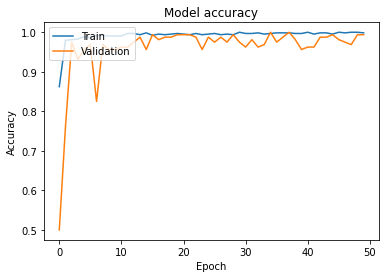

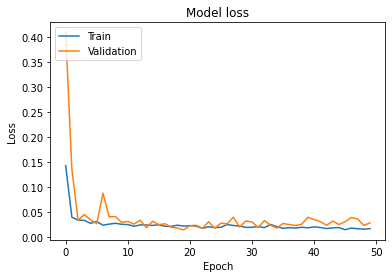

1/1 [==============================] - 0s 28ms/step
[[1.0615702]] [[0.07248382]]


In [ ]:
f12 = faceid_v1_2()
x = f12.show_graph()
cop1 = f12.create_wrong_rgbd('val')
cop2 = f12.create_couple_rgbd('val')
outputs1 = x.predict([cop1[0].reshape((1,200,200,3)), cop1[1].reshape((1,200,200,3))])
outputs2 = x.predict([cop2[0].reshape((1,200,200,3)), cop2[1].reshape((1,200,200,3))])
print(outputs1, outputs2)